In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("iamshahzaibkhan/deepfake-database")
print("Path to dataset files:", path)

100%|██████████| 182M/182M [00:01<00:00, 106MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iamshahzaibkhan/deepfake-database/versions/1


In [ ]:
import os

# Path from kagglehub
dataset_path = '/root/.cache/kagglehub/datasets/iamshahzaibkhan/deepfake-database/versions/1'
deepfake_dir = os.path.join(dataset_path, 'deepfake_database')

# List contents
print("Contents of deepfake_database:", os.listdir(deepfake_dir))

# Recursively explore the directory
for root, dirs, files in os.walk(deepfake_dir):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {len(files)}")

Contents of deepfake_database: ['validation', 'train', 'test']
Directory: /root/.cache/kagglehub/datasets/iamshahzaibkhan/deepfake-database/versions/1/deepfake_database
Subdirectories: ['validation', 'train', 'test']
Files: 0
Directory: /root/.cache/kagglehub/datasets/iamshahzaibkhan/deepfake-database/versions/1/deepfake_database/validation
Subdirectories: ['real', 'df']
Files: 0
Directory: /root/.cache/kagglehub/datasets/iamshahzaibkhan/deepfake-database/versions/1/deepfake_database/validation/real
Subdirectories: []
Files: 4259
Directory: /root/.cache/kagglehub/datasets/iamshahzaibkhan/deepfake-database/versions/1/deepfake_database/validation/df
Subdirectories: []
Files: 2845
Directory: /root/.cache/kagglehub/datasets/iamshahzaibkhan/deepfake-database/versions/1/deepfake_database/train
Subdirectories: ['real', 'df']
Files: 0
Directory: /root/.cache/kagglehub/datasets/iamshahzaibkhan/deepfake-database/versions/1/deepfake_database/train/real
Subdirectories: []
Files: 7085
Directory: /r

In [ ]:
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Source path (where the dataset is)
source_path = '/root/.cache/kagglehub/datasets/iamshahzaibkhan/deepfake-database/versions/1/deepfake_database'

# Destination path in Google Drive
drive_dataset_path = '/content/drive/MyDrive/deepfake_dataset'

# Copy the dataset to Drive
shutil.copytree(source_path, drive_dataset_path, dirs_exist_ok=True)

# Verify the copy
print("Dataset saved to:", drive_dataset_path)
!ls {drive_dataset_path}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset saved to: /content/drive/MyDrive/deepfake_dataset
test  train  validation


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize to [0, 1]
    horizontal_flip=True,     # Augmentation
    rotation_range=10,
    brightness_range=[0.8, 1.2]
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/deepfake_dataset/train',  # Train folder
    target_size=(224, 224),   # ResNet-50 input size
    batch_size=32,
    class_mode='binary'       # real=0, df=1
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/deepfake_dataset/validation',  # Validation folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Verify class labels
print(train_generator.class_indices)  # Should show {'real': 0, 'df': 1}

Found 12023 images belonging to 2 classes.
Found 7104 images belonging to 2 classes.
{'df': 0, 'real': 1}


In [ ]:
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
# Define dataset path
dataset_path = '/content/drive/MyDrive/deepfake_dataset'

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    brightness_range=[0.8, 1.2]
)
train_generator = train_datagen.flow_from_directory(
    f'{dataset_path}/train',
    target_size=(299, 299),  # Xception input size
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    f'{dataset_path}/validation',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    f'{dataset_path}/test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Calculate steps
train_steps = train_generator.samples // train_generator.batch_size  # 12023 // 32 = 375
val_steps = val_generator.samples // val_generator.batch_size        # 7104 // 32 = 222
test_steps = test_generator.samples // test_generator.batch_size     # 330 // 32 = 10

print(f"Train steps: {train_steps}, Validation steps: {val_steps}, Test steps: {test_steps}")

# Build Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Initial training for 8 epochs
print("Initial Training (8 epochs)...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=8
)


Found 12023 images belonging to 2 classes.
Found 7104 images belonging to 2 classes.
Found 330 images belonging to 2 classes.
Train steps: 375, Validation steps: 222, Test steps: 10
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Initial Training (8 epochs)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 547s 1s/step - accuracy: 0.8018 - loss: 0.4353 - val_accuracy: 0.8620 - val_loss: 0.3287
Epoch 2/8
  1/375 ━━━━━━━━━━━━━━━━━━━━ 1:32 246ms/step - accuracy: 0.9688 - loss: 0.2120

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - accuracy: 0.9688 - loss: 0.2120 - val_accuracy: 0.8346 - val_loss: 0.3727
Epoch 3/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 474s 1s/step - accuracy: 0.8973 - loss: 0.2563 - val_accuracy: 0.8649 - val_loss: 0.3085
Epoch 4/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - accuracy: 0.9062 - loss: 0.2280 - val_accuracy: 0.8689 - val_loss: 0.3013
Epoch 5/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 488s 1s/step - accuracy: 0.9271 - loss: 0.1823 - val_accuracy: 0.8773 - val_loss: 0.2968
Epoch 6/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 0.8750 - loss: 0.2568 - val_accuracy: 0.8895 - val_loss: 0.2768
Epoch 7/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.9431 - loss: 0.1604 - val_accuracy: 0.9084 - val_loss: 0.2276
Epoch 8/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - accuracy: 0.9062 - loss: 0.2092 - val_accuracy: 0.9071 - val_loss: 0.2296


NameError: name 'tf' is not defined

In [ ]:
import tensorflow as tf
# Fine-tuning: Unfreeze some layers
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all but last 20 layers
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune for 8 more epochs
print("Fine-Tuning (8 epochs)...")
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=8
)


Fine-Tuning (8 epochs)...
Epoch 1/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.8668 - loss: 0.3306 - val_accuracy: 0.8851 - val_loss: 0.2903
Epoch 2/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 219ms/step - accuracy: 0.9688 - loss: 0.1620 - val_accuracy: 0.8861 - val_loss: 0.2898
Epoch 3/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.9488 - loss: 0.1354 - val_accuracy: 0.8964 - val_loss: 0.2658
Epoch 4/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 60s 158ms/step - accuracy: 0.9688 - loss: 0.0368 - val_accuracy: 0.8957 - val_loss: 0.2669
Epoch 5/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.9675 - loss: 0.0880 - val_accuracy: 0.8947 - val_loss: 0.2773
Epoch 6/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - accuracy: 0.9688 - loss: 0.1326 - val_accuracy: 0.8937 - val_loss: 0.2787
Epoch 7/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.9748 - loss: 0.0702 - val_accuracy: 0.8988 - val_loss: 0.2708
Epoch 8/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - accuracy: 0.9688

375/375 ━━━━━━━━━━━━━━━━━━━━ 357s 947ms/step - accuracy: 0.9902 - loss: 0.0301
222/222 ━━━━━━━━━━━━━━━━━━━━ 61s 273ms/step - accuracy: 0.9114 - loss: 0.2169


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.9604 - loss: 0.1207

--- Final Metrics ---
Training Accuracy: 99.16% | Training Loss: 0.0270
Validation Accuracy: 89.92% | Validation Loss: 0.2712
Test Accuracy: 93.44% | Test Loss: 0.1786
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step


Model saved to: /content/drive/MyDrive/new_xception.h5

--- Classification Report ---
              precision    recall  f1-score   support

    Real (0)       0.91      0.97      0.94       165
    Fake (1)       0.97      0.90      0.93       155

    accuracy                           0.93       320
   macro avg       0.94      0.93      0.93       320
weighted avg       0.94      0.93      0.93       320



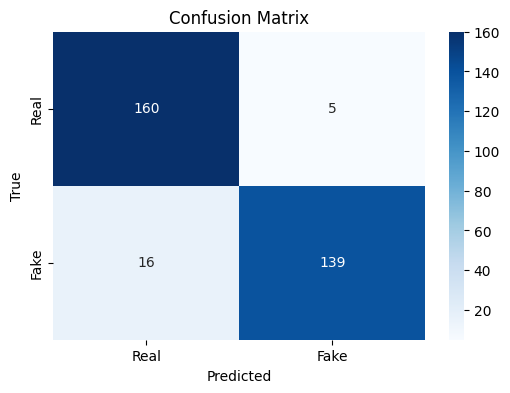

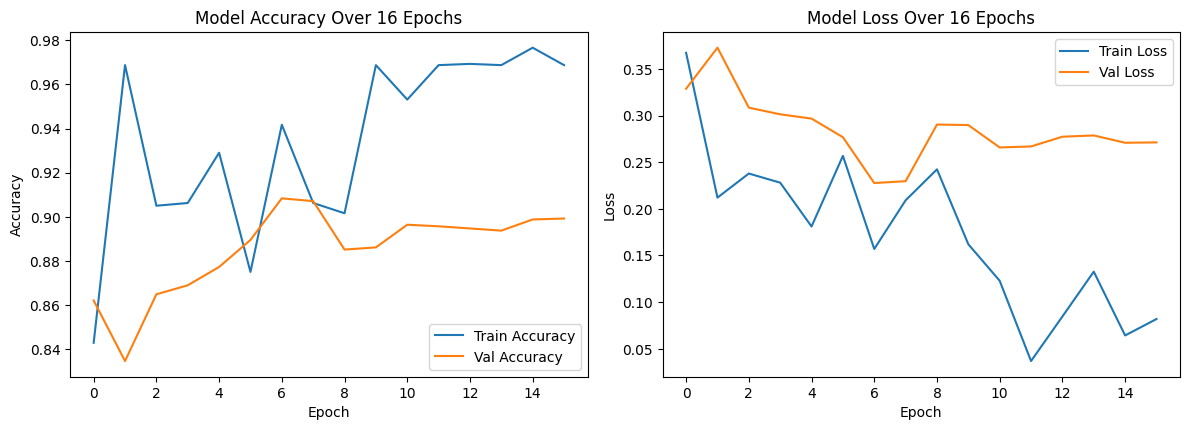

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Evaluate on all splits
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_steps)
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_steps)
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

# Print results
print("\n--- Final Metrics ---")
print(f"Training Accuracy: {train_accuracy * 100:.2f}% | Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}% | Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}% | Test Loss: {test_loss:.4f}")

# Generate predictions for test set
test_generator.reset()  # Reset generator to start from beginning
y_pred = model.predict(test_generator, steps=test_steps)
y_pred_binary = (y_pred >= 0.5).astype(int).flatten()  # Convert probabilities to 0 or 1
y_true = test_generator.classes[:len(y_pred)]  # True labels from test set

# Save model to Drive
model.save('/content/drive/MyDrive/new_xception.h5')
print("Model saved to: /content/drive/MyDrive/new_xception.h5")

# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_binary, target_names=['Real (0)', 'Fake (1)']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Plot accuracy and loss
plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over 16 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over 16 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save model to Drive
model.save('/content/drive/MyDrive/mini/new_xception.h5')
print("Model saved to: /content/drive/MyDrive/mini/new_xception.h5")

Model saved to: /content/drive/MyDrive/mini/new_xception.h5


Model loaded successfully.


Saving deep.png to deep (2).png
Uploaded image: deep (2).png
Image preprocessed with shape: (1, 299, 299, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction Score: 0.9337
Result: Fake


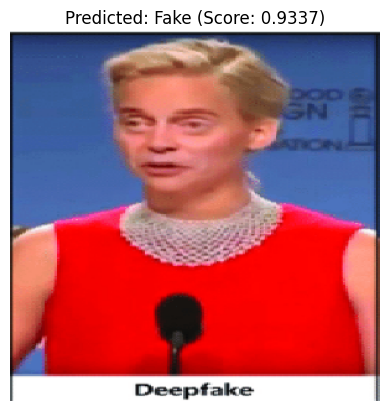

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the trained Xception model
model = load_model('/content/drive/MyDrive/new_xception.h5')
print("Model loaded successfully.")

# Upload test image
uploaded = files.upload()
image_filename = list(uploaded.keys())[0]
print("Uploaded image:", image_filename)

# Preprocess the image
img = load_img(image_filename, target_size=(299, 299))  # Xception input size
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
print("Image preprocessed with shape:", img_array.shape)

# Predict
prediction = model.predict(img_array)
score = prediction[0][0]
result = "Real" if score < 0.5 else "Fake"

# Print results
print(f"Prediction Score: {score:.4f}")
print(f"Result: {result}")

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {result} (Score: {score:.4f})")
plt.axis('off')
plt.show()

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import files

# Mount Google Drive
drive.mount('/content/drive')

# Define Drive dataset path
drive_dataset_path = '/content/drive/MyDrive/deepfake_dataset'

# Verify dataset exists and list contents
if os.path.exists(drive_dataset_path):
    print("Dataset exists at:", drive_dataset_path)
    print("Dataset contents:", os.listdir(drive_dataset_path))
    for root, dirs, files in os.walk(drive_dataset_path):
        print(f"Directory: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files: {len(files)}")
else:
    print(f"Directory {drive_dataset_path} not found. Please upload the dataset to Google Drive.")
    raise FileNotFoundError(f"Dataset not found at {drive_dataset_path}")

# Data Generators with improved augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up generators
dataset_path = drive_dataset_path
train_generator = train_datagen.flow_from_directory(
    f'{dataset_path}/train',
    target_size=(299, 299),  # Xception input size
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    f'{dataset_path}/validation',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    f'{dataset_path}/test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Verify class indices
print("Class indices:", train_generator.class_indices)

# Calculate steps per epoch
train_steps = max(1, train_generator.samples // train_generator.batch_size)
val_steps = max(1, val_generator.samples // val_generator.batch_size)
test_steps = max(1, test_generator.samples // test_generator.batch_size)
print(f"Train steps: {train_steps}, Validation steps: {val_steps}, Test steps: {test_steps}")

# Calculate class weights for imbalance
n_samples = train_generator.samples  # 12,023
n_real = 7085  # From your dataset
n_df = 4938    # From your dataset
class_weights = {
    0: n_samples / (2 * n_real),  # real=0, weight ≈ 0.85
    1: n_samples / (2 * n_df)     # df=1, weight ≈ 1.22
}
print("Class weights:", class_weights)

# Build Xception model with regularization
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze base model initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile with initial learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Initial training with class weights
print("Initial Training (up to 10 epochs)...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights,
    verbose=1
)

# Fine-tuning: Unfreeze more layers
base_model.trainable = True
for layer in base_model.layers[:-40]:  # Unfreeze last 40 layers
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning with class weights
print("Fine-Tuning (up to 10 epochs)...")
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights,
    verbose=1
)

# Evaluate on all splits
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_steps)
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_steps)
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

print("\n--- Final Metrics ---")
print(f"Training Accuracy: {train_accuracy * 100:.2f}% | Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}% | Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}% | Test Loss: {test_loss:.4f}")

# Predictions for test set
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_steps)
y_pred_binary = (y_pred >= 0.5).astype(int).flatten()
y_true = test_generator.classes[:len(y_pred)]

# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_binary, target_names=['Real (0)', 'Fake (1)']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save model
model_save_path = '/content/drive/MyDrive/deepfake_xception_final.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

# Test with a single image
print("\n--- Testing with a Single Image ---")
uploaded = files.upload()
if uploaded:
    image_filename = list(uploaded.keys())[0]
    print("Uploaded image:", image_filename)

    # Preprocess image
    img = load_img(image_filename, target_size=(299, 299))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    score = prediction[0][0]
    result = "Real" if score < 0.5 else "Fake"

    # Display result
    print(f"Prediction Score: {score:.4f}")
    print(f"Result: {result}")
    plt.imshow(img)
    plt.title(f"Predicted: {result} (Score: {score:.4f})")
    plt.axis('off')
    plt.show()
else:
    print("No image uploaded.")